In [1]:
import torch 
import copy
import json 
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose   
from types import SimpleNamespace


OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16} 
from utils_pdhg import *


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_pd_adamw_warm_start_only",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start_only/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_pd_adamw_warm_start_only and learning rate 0.001
[AttnPDAdamW] lr=0.001, betas=(0.95, 0.95), eps=1e-08, wd=0.0, qk_lr_scale=1.0, max_norm_tr=0.001, pdhg_iters=0, warm_start=True, lsqr_max_iter=1000
    momentum=False, diag_scaling=True, pd_type='pdhg', reflected_halpern=False, enable_restart=False
Set pass_loss to False for optimizer AttnPDAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 6.731194019317627
In rank: 0, time tak

In [3]:
from omegaconf import OmegaConf
import os, json
from types import SimpleNamespace

output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start_only/bs-4-lr-0.001-wd-0"
cfg = OmegaConf.load(os.path.join(output_dir, ".hydra", "config.yaml"))

output_path = make_output_path_hydra(cfg, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    logger = SimpleNamespace(**json.load(f))

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start_only/bs-4-lr-0.001-wd-0/attn_pd_adamw_warm_start_only-lr-0.001-constant-linear-c77ebd6594afd80c5f9321540cb18332.json


iteration=0
  layer    A1_norm    A2_norm   G2_norm   G1_norm    Y_norm
0     0  54.651184  43.855755  0.013236  0.013624  0.045108
1     1  48.869389  56.696659  0.003661  0.003805  0.013356
2     2  71.552101  83.162430  0.001971  0.002149  0.007391
3     3  42.161507  49.637676  0.001707  0.001681  0.005925


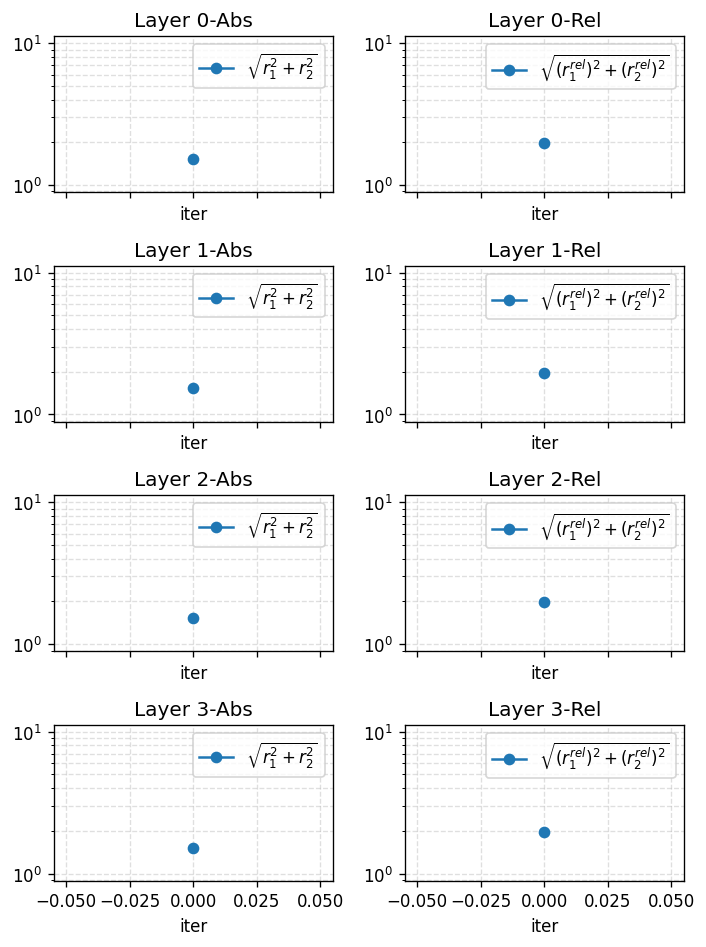

In [4]:
it = 0
print(f"iteration={it}")
import pandas as pd
it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "A1_norm": layer_res["A1_norm"], "A2_norm": layer_res["A2_norm"],
        "G2_norm": layer_res["G2_norm"], "G1_norm": layer_res["G1_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)

plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

In [5]:
layer_res.keys()

dict_keys(['r1', 'r2', 'r1_rel', 'r2_rel', 'A1_norm', 'A2_norm', 'G1_norm', 'G2_norm', 'Y_norm'])

iteration=50
  layer     A1_norm     A2_norm   G2_norm   G1_norm    Y_norm
0     0   70.024323   27.693083  0.467306  0.156153  5.692642
1     1  108.965866   90.737289  0.066410  0.001088  0.144049
2     2  104.042145  400.146973  0.000180  0.001121  0.005171
3     3  266.676544  255.401215  0.000810  0.000042  0.000694


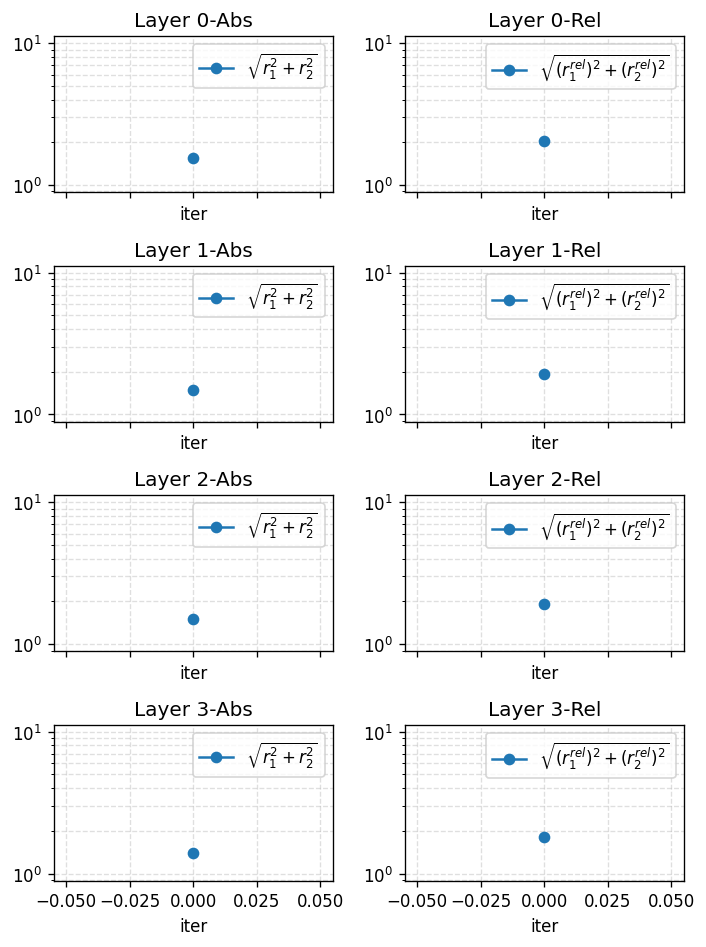

In [6]:
it = 50
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "A1_norm": layer_res["A1_norm"], "A2_norm": layer_res["A2_norm"],
        "G2_norm": layer_res["G2_norm"], "G1_norm": layer_res["G1_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=-1
  layer     A1_norm     A2_norm   G2_norm   G1_norm    Y_norm
0     0   56.640820  159.725479  0.179153  0.019952  1.331128
1     1   33.983971   95.234825  0.003688  0.000171  0.017629
2     2  128.878067  128.497543  0.000041  0.000849  0.005403
3     3  140.842575   68.048599  0.001716  0.000161  0.005541


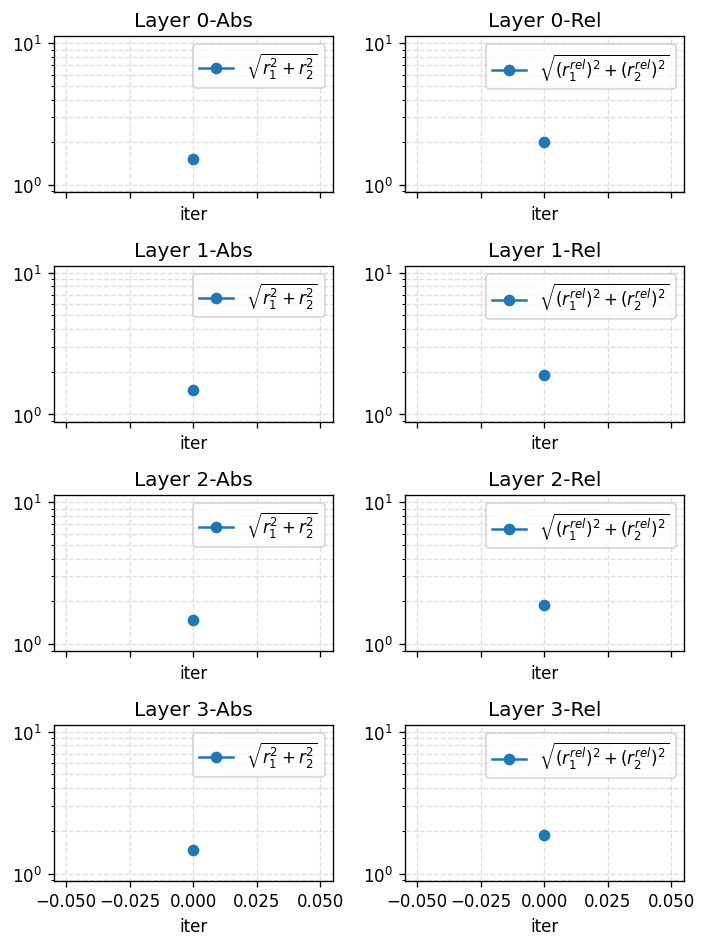

In [7]:
it = -1
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "A1_norm": layer_res["A1_norm"], "A2_norm": layer_res["A2_norm"],
        "G2_norm": layer_res["G2_norm"], "G1_norm": layer_res["G1_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)